In [13]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq
import ivac
from extq.stop import forward_stop

In [14]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [15]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

/scratch/local/jobs/278587/ipykernel_578727/1819589819.py:20: UserWarning: Trying to register the cmap 'diverging' which already exists.
  mpl.colormaps.register(cm_div, force=True)


In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    0
]  # 0.1 ns lag time
j_du_sb = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_sb_3.npy", allow_pickle=True)[
    6
]

In [6]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [7]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# Committors

In [8]:
# compute E[\theta(x) S_tq_+(x)]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

In [9]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

In [10]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [11]:
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.05, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("black", colors_black)
mpl.colormaps.register(cmapblack, force=True)

In [12]:
def plot_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned ** 2 + jy_binned ** 2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )

    return ax, quiv

/scratch/local/jobs/4733280/ipykernel_1722205/590402791.py:48: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa2772593a0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/4733280/ipykernel_1722205/590402791.py:48: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa27718ec70> has a label of '_' which cannot be automatically added to the legend.
  f.legend(


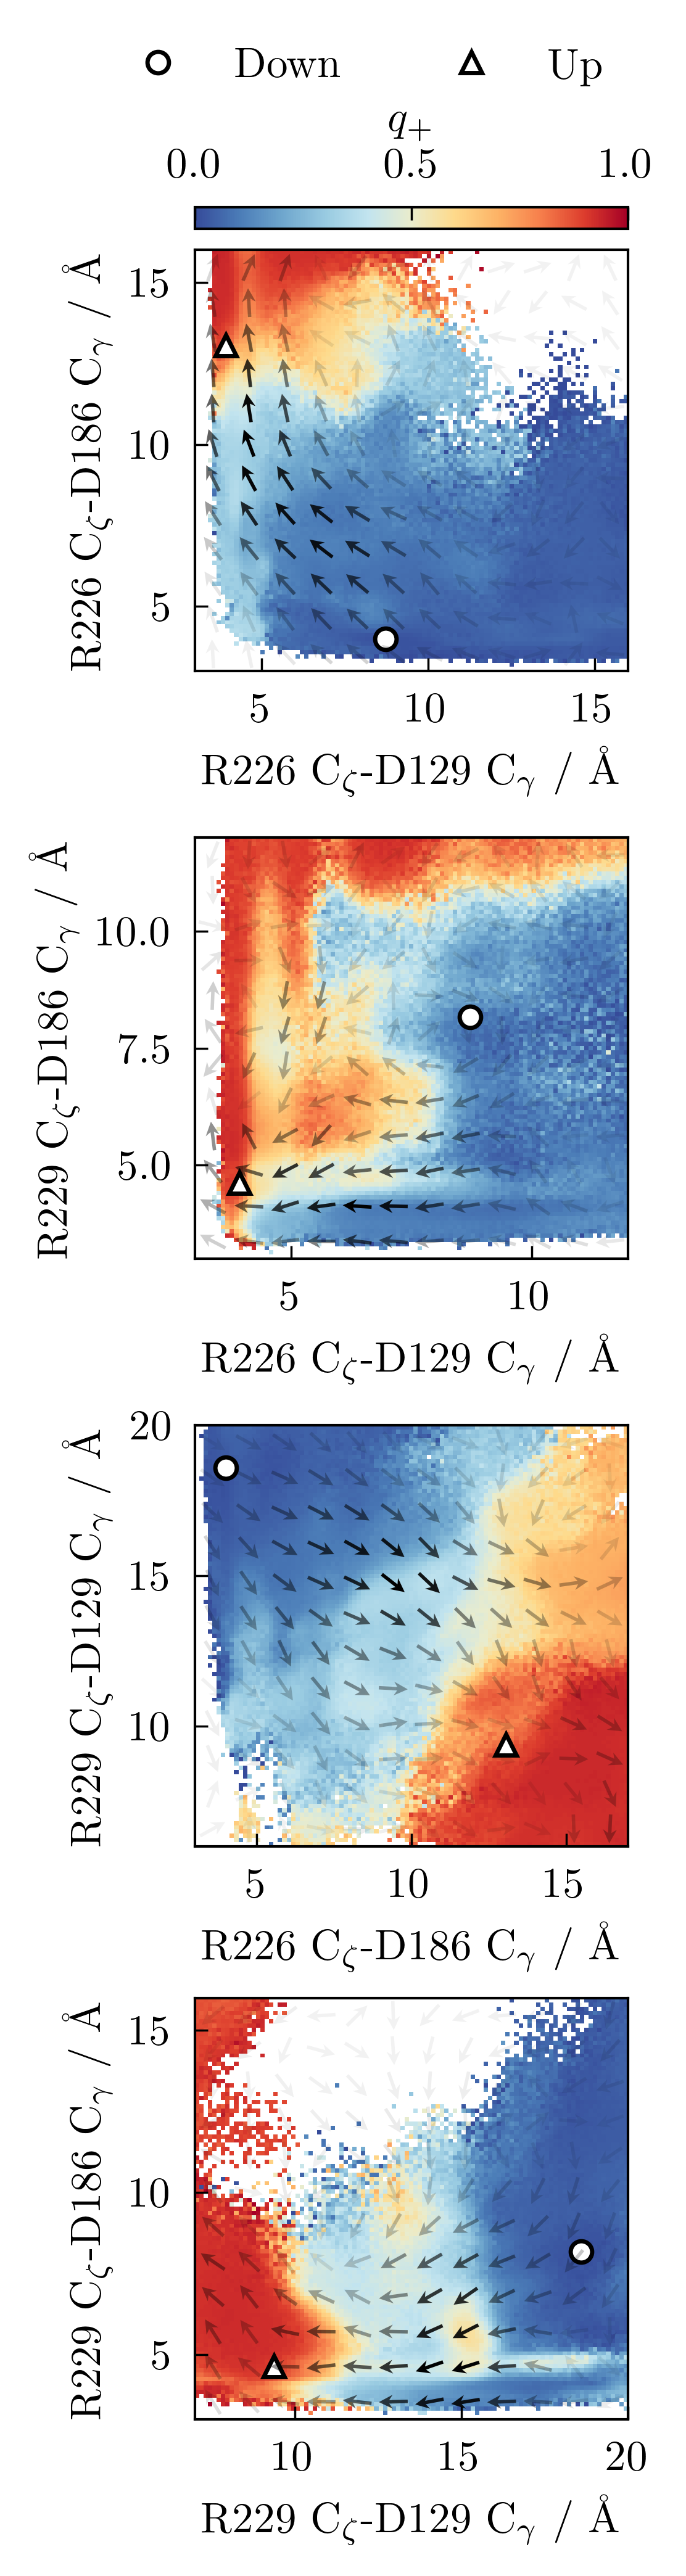

In [45]:
f, axes = plt.subplots(4, 1, figsize=(2.0, 8.0), dpi=500, constrained_layout=True)

range0 = [[3, 16], [3, 16]]
range1 = [[3, 12], [3, 12]]
range2 = [[3, 17], [6, 20]]
range3 = [[7, 20], [3, 16]]
nbin = 100
sb_ids = [42, 48, 47, 53]
levels = np.linspace(0, 1, 41)

for ((i, j), ax, r) in zip(
    ((0, 2), (0, 3), (2, 1), (1, 3)),
    axes.flat,
    (range0, range1, range2, range3),
):
    sb1, sb2 = sb_ids[i], sb_ids[j]
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5)

    sb1_lag = [t[:-lag, sb1] * 10 for t in sb_trajs]
    sb2_lag = [t[:-lag, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    xc = (xlim[1:] + xlim[:-1]) / 2
    yc = (ylim[1:] + ylim[:-1]) / 2
    q_dens = extq.projection.average2d(sb1_lag, sb2_lag, qp_delay, w_delay, xlim, ylim)
    h = ax.pcolormesh(xc, yc, q_dens.T, cmap=cm_div, vmin=0, vmax=1)

    sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
    sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    ax, quiv = plot_current(
        sb0_trajs,
        sb1_trajs,
        j_du_sb[:, [i, j]],
        weights,
        *r[0],
        *r[1],
        12,
        ax=ax,
        cm_j="black",
    )
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )
    ax.set_xlim(r[0])
    ax.set_ylim(r[1])

f.legend(
    bbox_to_anchor=(0.5, 1.01),
    loc="center",
    ncol=3,
    labels=["_", "Down", "Up", "_"],
)
cb = plt.colorbar(h, ax=axes[0], orientation='horizontal', location='top')
cb.set_label("$q_+$")

/scratch/local/jobs/4733280/ipykernel_1722205/4048770586.py:27: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
/scratch/local/jobs/4733280/ipykernel_1722205/4048770586.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa276995a00> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/4733280/ipykernel_1722205/4048770586.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa2768a1460> has a label of '_' which cannot be automatically added to the legend.
  f.legend(


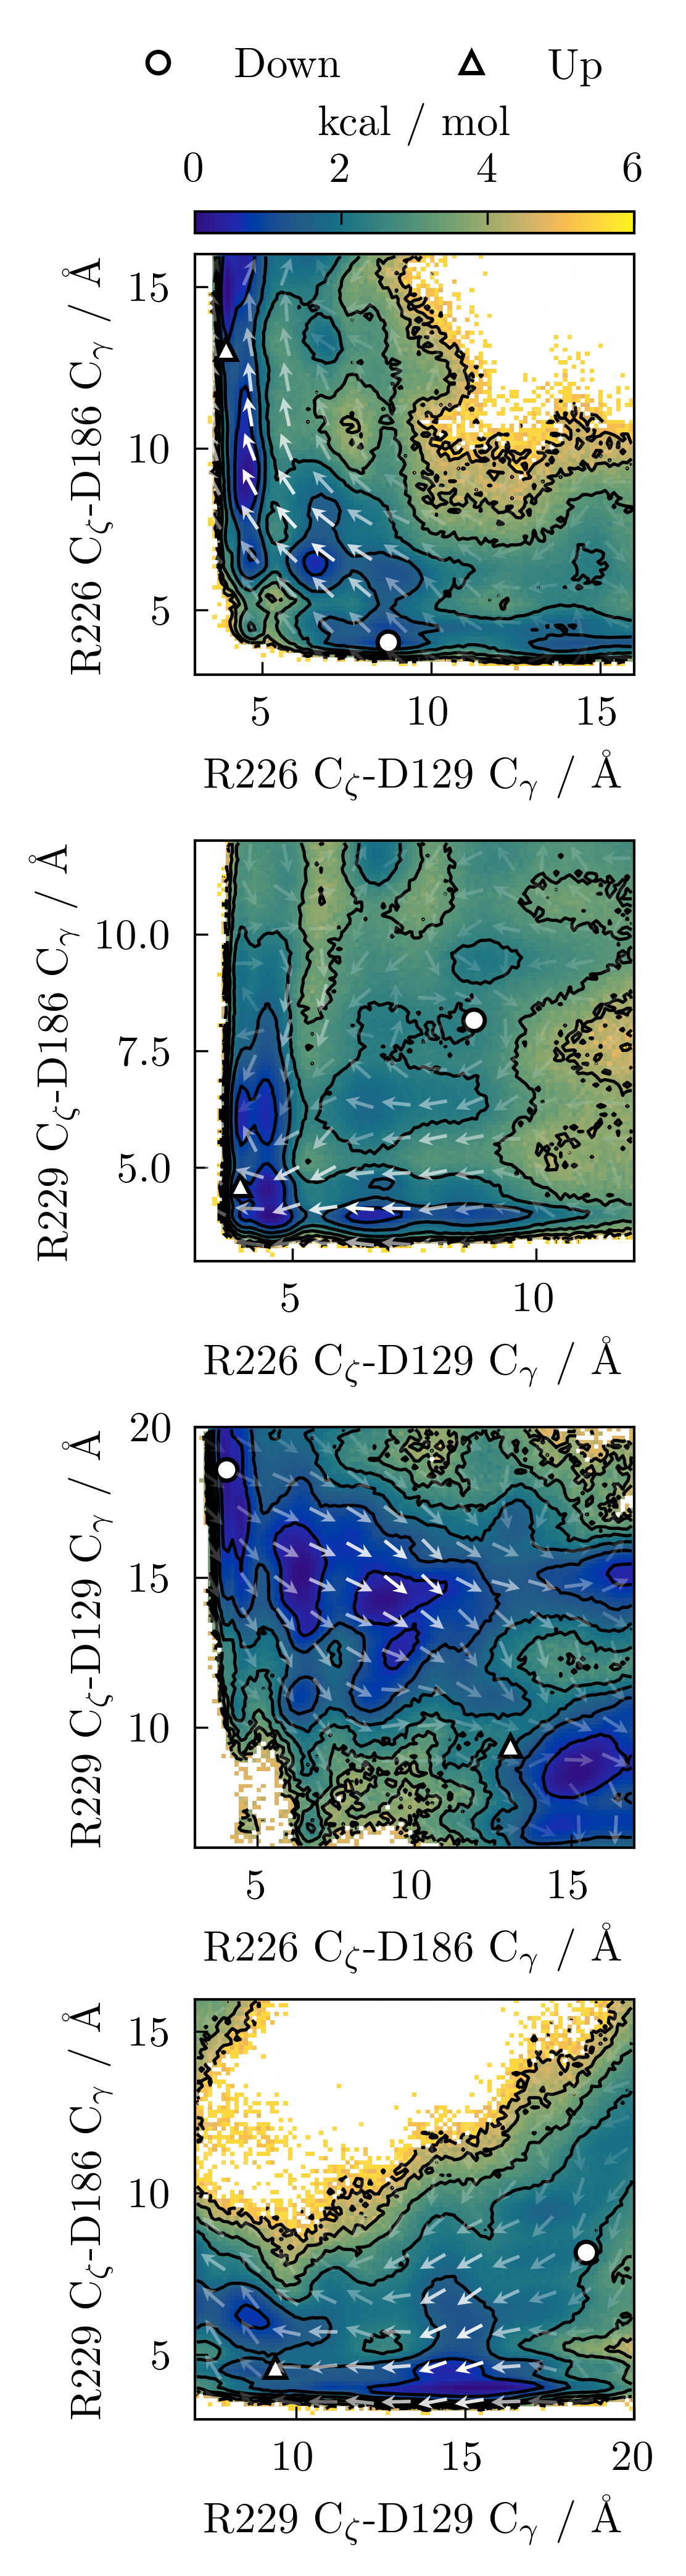

In [48]:
f, axes = plt.subplots(4, 1, figsize=(2.0, 8.0), dpi=500, constrained_layout=True)

range0 = [[3, 16], [3, 16]]
range1 = [[3, 12], [3, 12]]
range2 = [[3, 17], [6, 20]]
range3 = [[7, 20], [3, 16]]
nbin = 100
sb_ids = [42, 48, 47, 53]
levels = np.linspace(0, 1, 41)

for ((i, j), ax, r) in zip(
    ((0, 2), (0, 3), (2, 1), (1, 3)),
    axes.flat,
    (range0, range1, range2, range3),
):
    sb1, sb2 = sb_ids[i], sb_ids[j]
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5, zorder=5)

    sb0_trajs = [t[:, sb1] * 10 for t in sb_trajs]  # in Angstroms
    sb1_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)
    xc = (xlim[1:] + xlim[:-1]) / 2
    yc = (ylim[1:] + ylim[:-1]) / 2
    pmf = extq.projection.density2d(sb0_trajs, sb1_trajs, weights, xlim, ylim)
    offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
    h = ax.pcolormesh(xc, yc, diff.T, cmap='macaw', vmin=0, vmax=6, rasterized=True)
    ax.contour(xc, yc, diff.T, colors="black")

    ax, quiv = plot_current(
        sb0_trajs,
        sb1_trajs,
        j_du_sb[:, [i, j]],
        weights,
        *r[0],
        *r[1],
        12,
        ax=ax,
        cm_j=cmapwhite,
    )
    ax.set(
        xlabel=f"{sb_names[sb1]} / Å",
        ylabel=f"{sb_names[sb2]} / Å",
    )
    ax.set_xlim(r[0])
    ax.set_ylim(r[1])

f.legend(
    bbox_to_anchor=(0.5, 1.01),
    loc="center",
    ncol=3,
    labels=["_", "Down", "Up", "_"],
)
cb = plt.colorbar(h, ax=axes[0], orientation='horizontal', location='top')
cb.set_label("kcal / mol")

# Violin plots

In [17]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

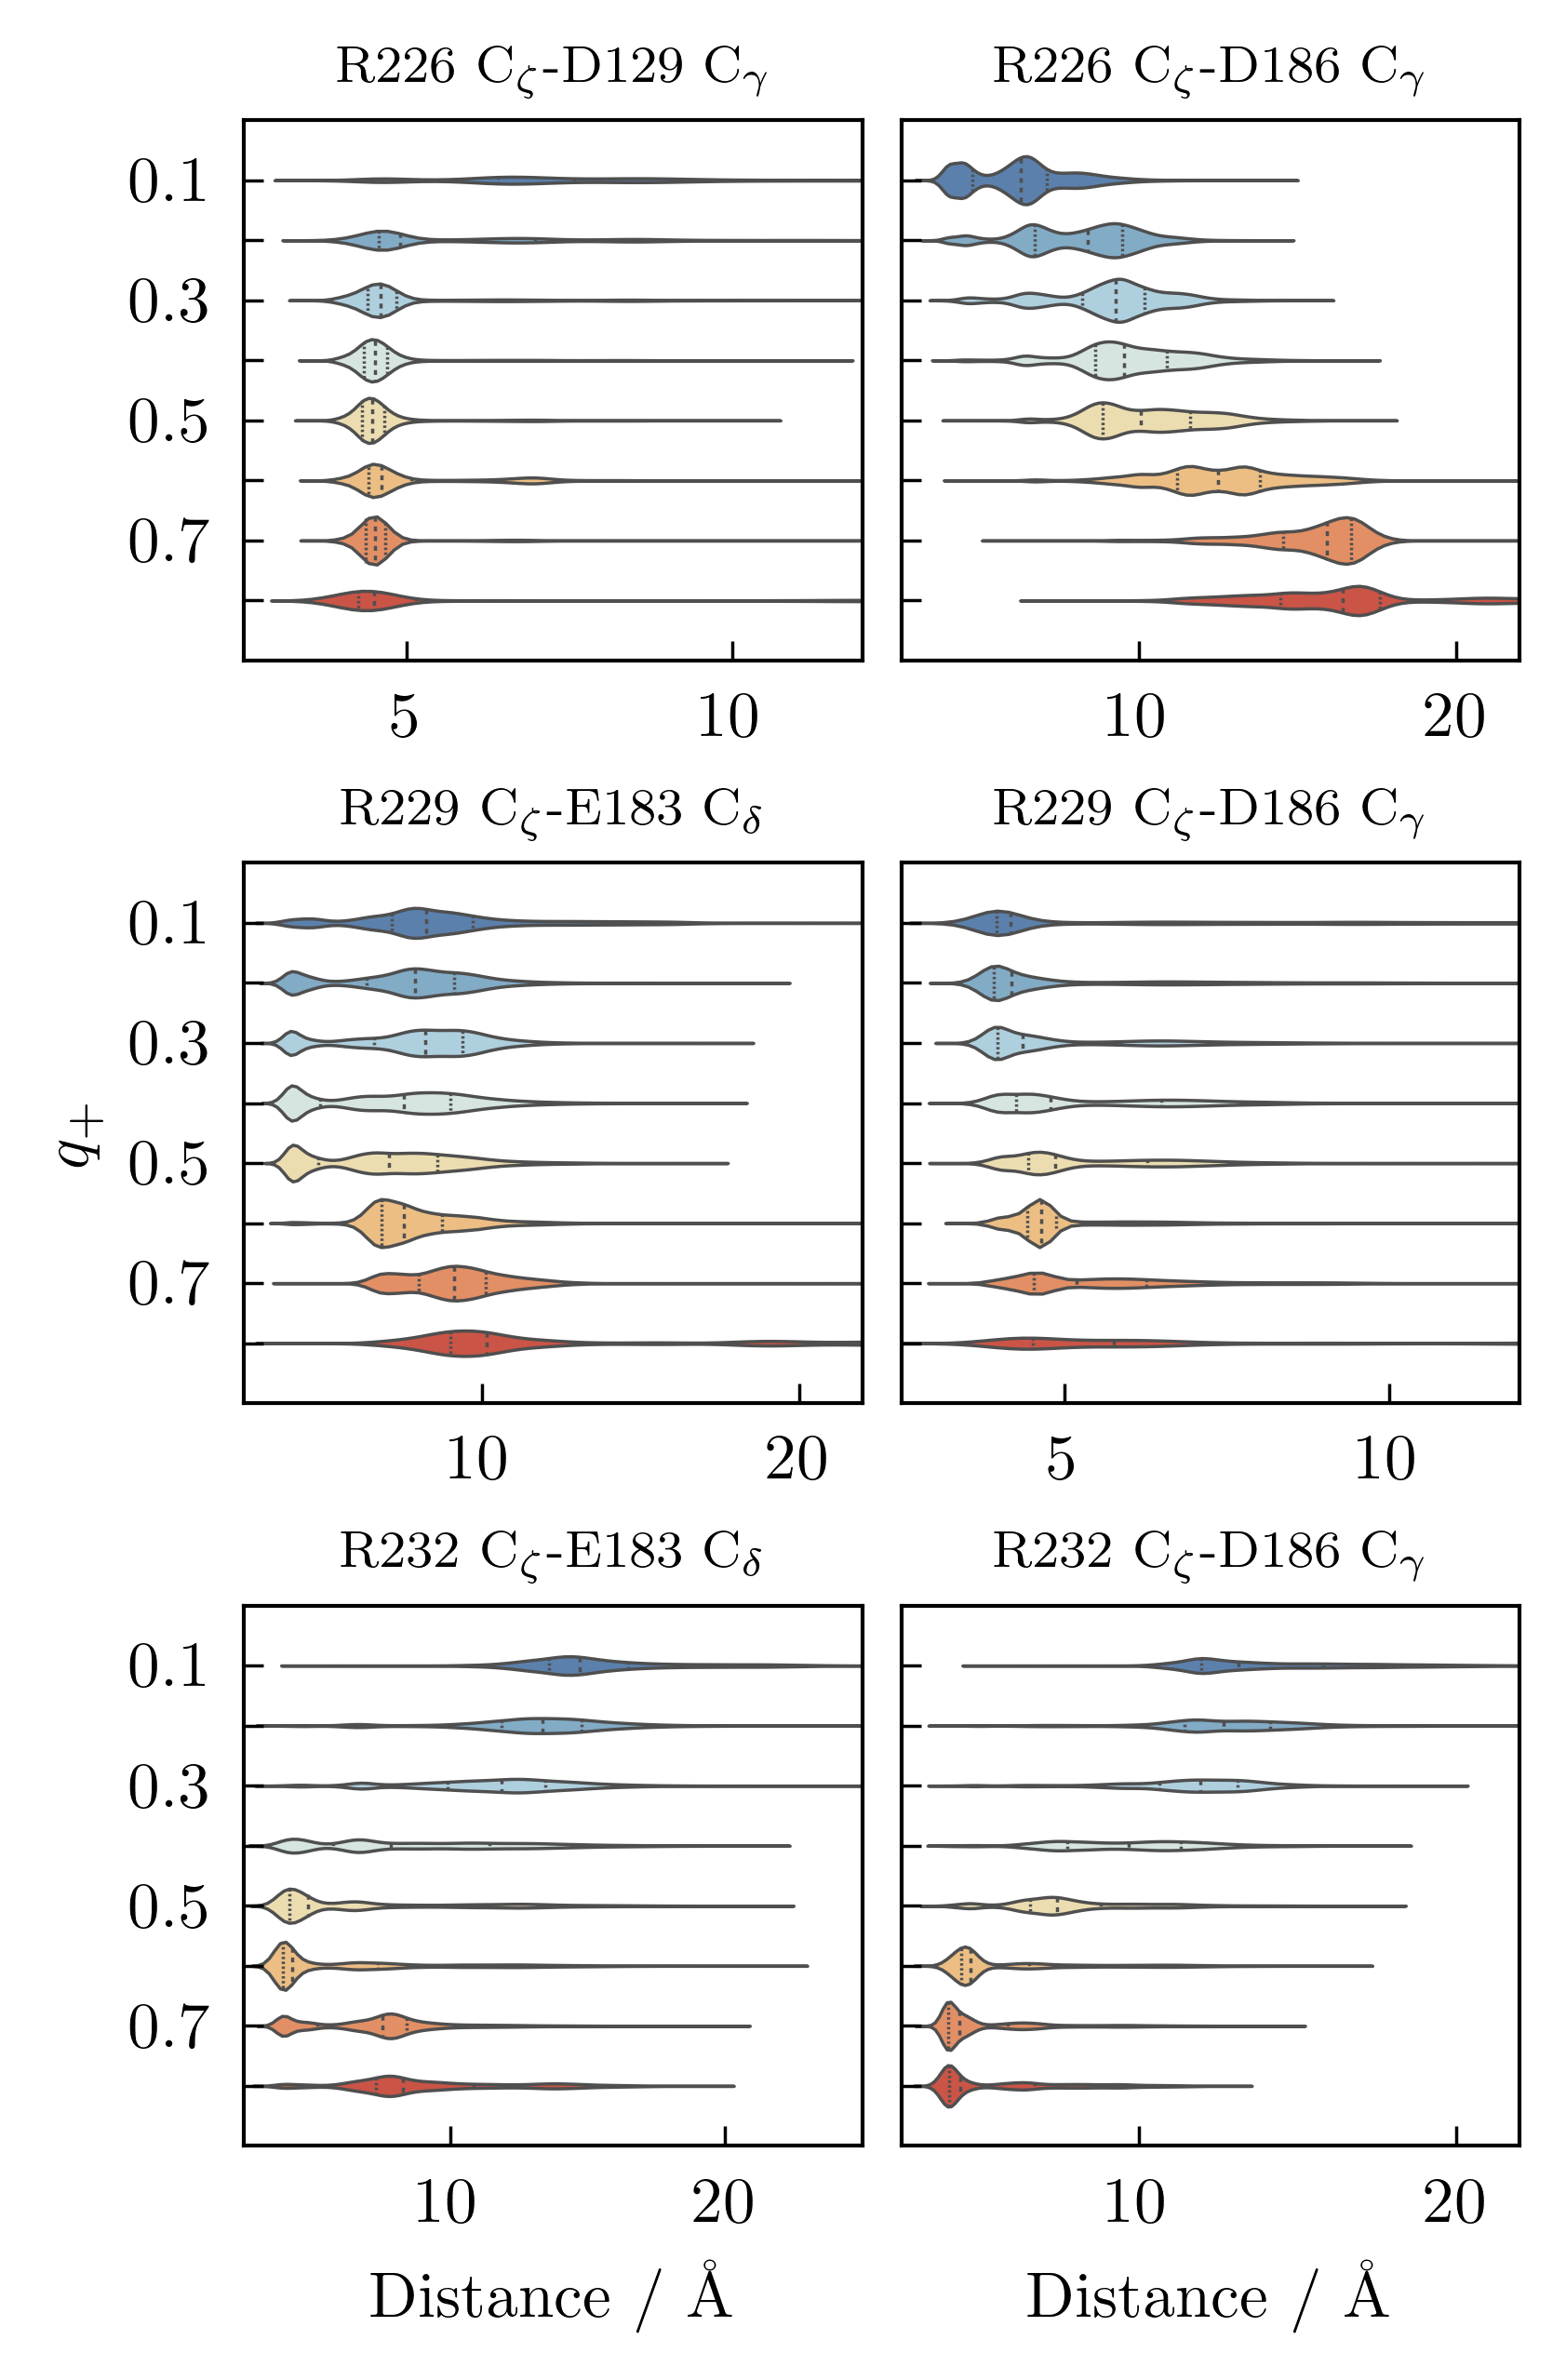

In [18]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.05, hi=0.85)

steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

f, axs = plt.subplots(
    3, 2, figsize=(3.25, 5.0), dpi=500, sharey=True, constrained_layout=True
)

sb_ids = [42, 47, 52, 53, 58, 59]
xmax = [12, 22, 22, 12, 25, 22]
for i, ax, xhi in zip(sb_ids, axs.flat, xmax):
    sns.violinplot(
        ax=ax,
        data=[sb_arr[inds, i] * 10 for inds in q_inds],
        orient="h",
        scale="area",
        bw=0.1,
        inner="quartile",
        palette="diverging",
        linewidth=0.5,
    )
    # ax.set_xlabel(f"{sb_names[i]} / Å")
    ax.set_title(f"{sb_names[i]}", fontsize=8)
    ax.set_yticklabels(steplabels)
    ax.set_xlim([2.5, xhi])
    ax.set_ylim([-1, 8])
    ax.invert_yaxis()
axs[1, 0].set_ylabel("$q_+$")
axs[2, 0].set_xlabel("Distance / Å")
axs[2, 1].set_xlabel("Distance / Å")
plt.savefig("../../fig/paper/sb_violins.pdf", bbox_inches='tight')